In [ ]:
!pip install gcsfs --no-deps

In [ ]:
!pip show datasets
!pip show fsspec
!pip show gcsfs


Name: datasets
Version: 3.2.0
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, dill, filelock, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyyaml, requests, tqdm, xxhash
Required-by: 
Name: fsspec
Version: 2024.9.0
Summary: File-system specification
Home-page: https://github.com/fsspec/filesystem_spec
Author: 
Author-email: 
License: BSD 3-Clause License
        
        Copyright (c) 2018, Martin Durant
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following d

In [ ]:
!pip install transformers datasets torch pandas scikit-learn matplotlib

In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# Cargar el dataset
df = pd.read_csv("Emojis_clean_corregido.csv")
df_sample = df.sample(4000, random_state=42)

# Mostrar una muestra del dataset
print(df_sample.head())

                                                  tweet sentimiento
1782  nunca sabremos cuanto dinero se robaron en la ...        asco
3917  mi hija está sembrado mucho amor. papi, tengo ...       miedo
221             lo tercero es lo difícil 😂 yo parecería     alegria
2135  reportecovid covid colombia covid coronavirus ...         ira
5224                             devaluados otra vez. 😓    tristeza


In [ ]:
sentimientos = {'alegria': 0, 'asco': 1, 'ira': 2, 'miedo': 3, 'sorpresa': 4, 'tristeza': 5}
df_sample['sentimiento'] = df_sample['sentimiento'].replace(sentimientos)


<ipython-input-6-a6e978766116>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sample['sentimiento'] = df_sample['sentimiento'].replace(sentimientos)


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_sample['tweet'].tolist(), df_sample['sentimiento'].tolist(), test_size=0.2, random_state=42
)


In [ ]:
from transformers import RobertaTokenizer

# Descargar el tokenizer en español
tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')

# Tokenización de los textos
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [ ]:
from transformers import RobertaForSequenceClassification

# Cargar el modelo RoBERTa en español
model = RobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=6)

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"  # Disables logging to W&B
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.650600,0.452617,0.856250,0.858301,0.868474,0.856250
2,0.223900,0.484567,0.865000,0.867436,0.878829,0.865000


TrainOutput(global_step=800, training_loss=0.4195515290647745, metrics={'train_runtime': 22638.8058, 'train_samples_per_second': 0.283, 'train_steps_per_second': 0.035, 'total_flos': 963678848947200.0, 'train_loss': 0.4195515290647745, 'epoch': 2.0})

In [ ]:
eval_result = trainer.evaluate()
print(eval_result)


{'eval_loss': 0.4845674932003021, 'eval_accuracy': 0.865, 'eval_f1': 0.8674359608868417, 'eval_precision': 0.8788285339373778, 'eval_recall': 0.865, 'eval_runtime': 632.7957, 'eval_samples_per_second': 1.264, 'eval_steps_per_second': 0.158, 'epoch': 2.0}


In [ ]:
model.save_pretrained("sentiment_roberta_model")
tokenizer.save_pretrained("sentiment_roberta_model")


('sentiment_roberta_model/tokenizer_config.json',
 'sentiment_roberta_model/special_tokens_map.json',
 'sentiment_roberta_model/vocab.json',
 'sentiment_roberta_model/merges.txt',
 'sentiment_roberta_model/added_tokens.json')

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="sentiment_roberta_model", tokenizer="sentiment_roberta_model")

# Ejemplo de predicción
texto = "No me gusta la política en Venezuela 😡"
resultado = classifier(texto)
print(resultado)


[{'label': 'LABEL_2', 'score': 0.9905270338058472}]


Cargar el Modelo para Predicción
Carga el modelo y el tokenizer guardados para realizar predicciones en nuevos comentarios.

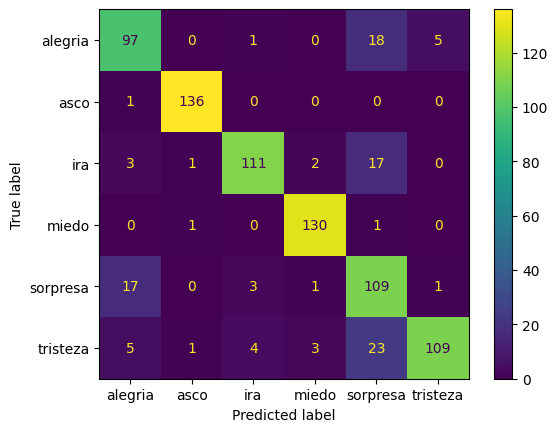

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(sentimientos.keys()))
disp.plot(cmap='viridis')


Revisar la Matriz de Confusión:
Para entender dónde está fallando el modelo, puedes generar una matriz de confusión.

In [ ]:
nuevos_comentarios = [
    "Me voy del país, no aguanto más esta situación",
    "Estoy feliz de comenzar una nueva vida en otro lugar 😡",
    "La situación política es insostenible 😊"
]

for comentario in nuevos_comentarios:
    resultado = classifier(comentario)
    print(f"Comentario: {comentario}\nResultado: {resultado}\n")


Comentario: Me voy del país, no aguanto más esta situación
Resultado: [{'label': 'LABEL_4', 'score': 0.8016497492790222}]

Comentario: Estoy feliz de comenzar una nueva vida en otro lugar 😡
Resultado: [{'label': 'LABEL_2', 'score': 0.9902771711349487}]

Comentario: La situación política es insostenible 😊
Resultado: [{'label': 'LABEL_0', 'score': 0.9876060485839844}]



In [ ]:
# Comprimir la carpeta del modelo
!zip -r sentiment_roberta_model.zip sentiment_roberta_model

from google.colab import files

# Descargar el archivo zip
files.download("sentiment_roberta_model.zip")

  adding: sentiment_roberta_model/ (stored 0%)
  adding: sentiment_roberta_model/merges.txt (deflated 56%)
  adding: sentiment_roberta_model/special_tokens_map.json (deflated 85%)
  adding: sentiment_roberta_model/tokenizer_config.json (deflated 76%)
  adding: sentiment_roberta_model/vocab.json (deflated 69%)
  adding: sentiment_roberta_model/model.safetensors (deflated 15%)
  adding: sentiment_roberta_model/config.json (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Entrenando el modelo con migración y política

In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import pipeline

# Cargar tokenizer y modelo preentrenado de sentimientos
tokenizer = RobertaTokenizer.from_pretrained("./")
model = RobertaForSequenceClassification.from_pretrained(
    "./",
    from_safetensors=True,
    num_labels=6  # 6 etiquetas de sentimiento: alegría, asco, ira, miedo, sorpresa, tristeza
)

print("Modelo y tokenizer cargados correctamente")




ModuleNotFoundError: No module named 'datasets'